# __3D TECHNOLOGIES__

__REPORT: On Reducing Maintenance Cost__


__Elaborated by: Sergio Nieto__

__Objective__

This document is a report on the work done by *The Data Science Team* building a predictive model using machine learning to predict the probability of a device failure. 

__Context__

The data is about a fleet of devices transmitting daily aggregated telemetry
attributes.
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

In [1]:
# The libraries we'll use in this report are:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.lines as mlines
from IPython.core.pylabtools import figsize
import warnings
import pickle

# Processing
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_val_predict,cross_val_score,ShuffleSplit
from sklearn.feature_selection import SelectKBest, SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Representation Learning for the autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

# Evaluation
from sklearn.metrics import roc_curve,auc, roc_auc_score,accuracy_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, balanced_accuracy_score,precision_score,average_precision_score, precision_recall_curve

plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set()

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')
print(f'pandas   {pd.__version__}')

sklearn    0.23.1
tensorflow 2.2.0
keras      2.3.0-tf
numpy      1.18.5
pandas   1.0.4


In [3]:
# 
tf.random.set_seed(2020)
np.random.seed(2020)

In [3]:
# We check that it is a csv file
# cat device_failure.csv | head 
# shows no problem
# since we know nothing about the file encoding, latin-1 will be used.

# Exploratory Data Analysis 

In [4]:
devices = pd.read_csv("device_failure.csv", encoding='Latin-1')

In [5]:
devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
# Number of different devices

devices.device.nunique()

1169

In [7]:
# How many different dates?

devices.date.nunique()

304

In [8]:
# Not all devices have the same number of records
# This may be a disadvantage for a time series approach to detecting failure

# we take to examples from the previous head:

devices[devices.device == "S1F01085"]["date"].nunique()

6

In [9]:
devices[devices.device == "S1F01E6Y"]["date"].nunique()

48

In [10]:
# Before proceeding, we look at the info in the data frame:

devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [11]:
# We have more than 100 thounsand records, but haw many are failures?

devices.failure.value_counts(normalize=True)

0    0.999149
1    0.000851
Name: failure, dtype: float64

In [12]:
# Date are converted to datetime from pandas in case we need to use later on these functionality

devices["date"]=pd.to_datetime(devices["date"])

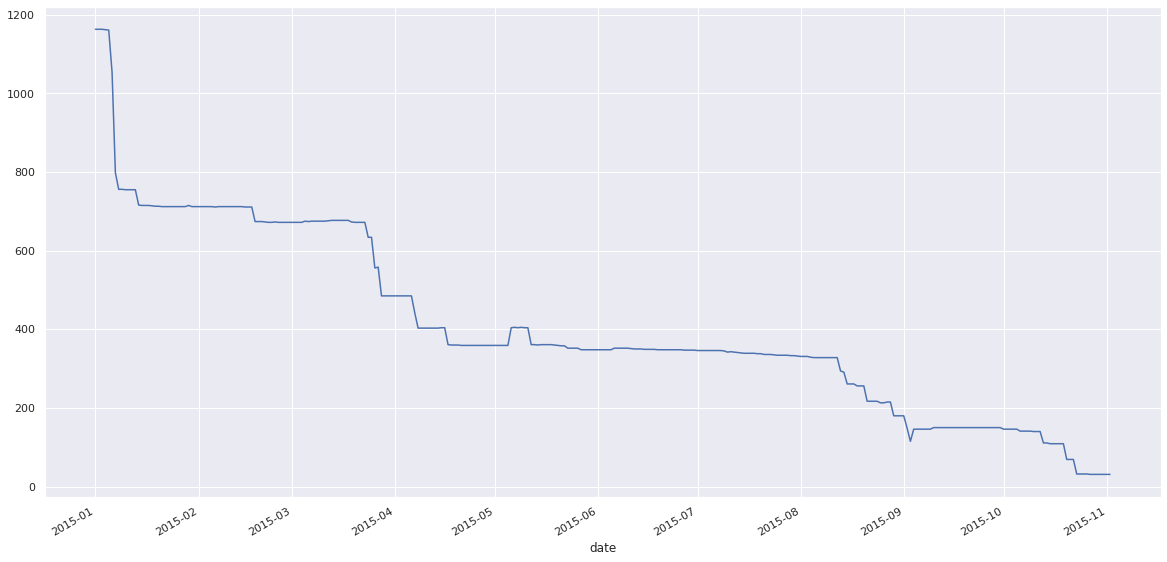

In [13]:
# Since we know

devices.groupby(["date"])["device"].nunique().plot()

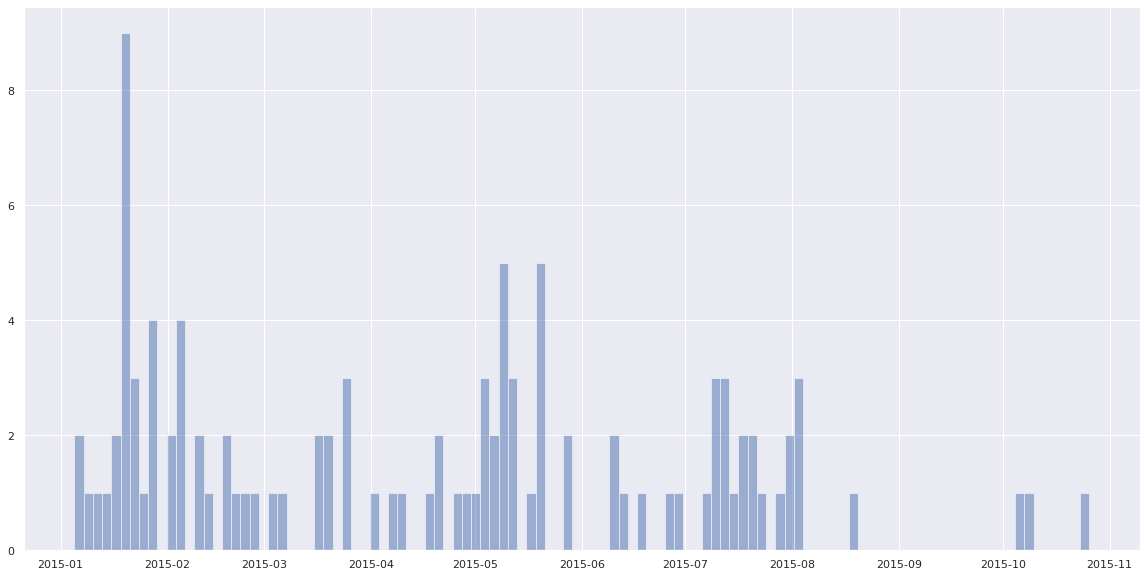

In [14]:
devices.query("(failure == 1)").date.hist(bins = 110, alpha = 0.5)

In [15]:
devices.groupby(["device"])["date"].count().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: date, dtype: float64

__Create a data frame based only on failures to understand better the structure of the time series__

In [16]:
list_failures=list(set(devices[devices.failure == 1]['device']))
devices.loc[devices.device.isin(list_failures),"tag"] = 1
devices.loc[~devices.device.isin(list_failures),"tag"] = 2

In [17]:
failures = devices[devices.tag == 1]
non_failures = devices[devices.tag == 2]

In [18]:
non_failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2.0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2.0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2.0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2.0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2.0


In [19]:
failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,1.0
23,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0,1.0
44,2015-01-01,S1F09DZQ,0,12568128,136,0,2,6,380112,0,0,2,1.0
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3,1.0
74,2015-01-01,S1F0DSTY,0,8471680,0,0,0,11,436682,0,0,0,1.0


In [20]:
failures.device.nunique()

106

In [21]:
failures.groupby("device").date.describe().reset_index().head()

,device,count,unique,top,freq,first,last
0,S1F023H2,19,19,2015-01-04,1,2015-01-01,2015-01-19
1,S1F03YZM,215,215,2015-07-19,1,2015-01-01,2015-08-03
2,S1F09DZQ,199,199,2015-01-31,1,2015-01-01,2015-07-18
3,S1F0CTDN,7,7,2015-01-04,1,2015-01-01,2015-01-07
4,S1F0DSTY,45,45,2015-02-01,1,2015-01-01,2015-02-14


In [22]:
failures_desc = failures.groupby("device").date.describe().reset_index()
failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
non_failures_desc = non_failures.groupby("device").date.describe().reset_index()
non_failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


In [23]:
failures_desc["first"].describe()

count                     106
unique                      1
top       2015-01-01 00:00:00
freq                      106
first     2015-01-01 00:00:00
last      2015-01-01 00:00:00
Name: first, dtype: object

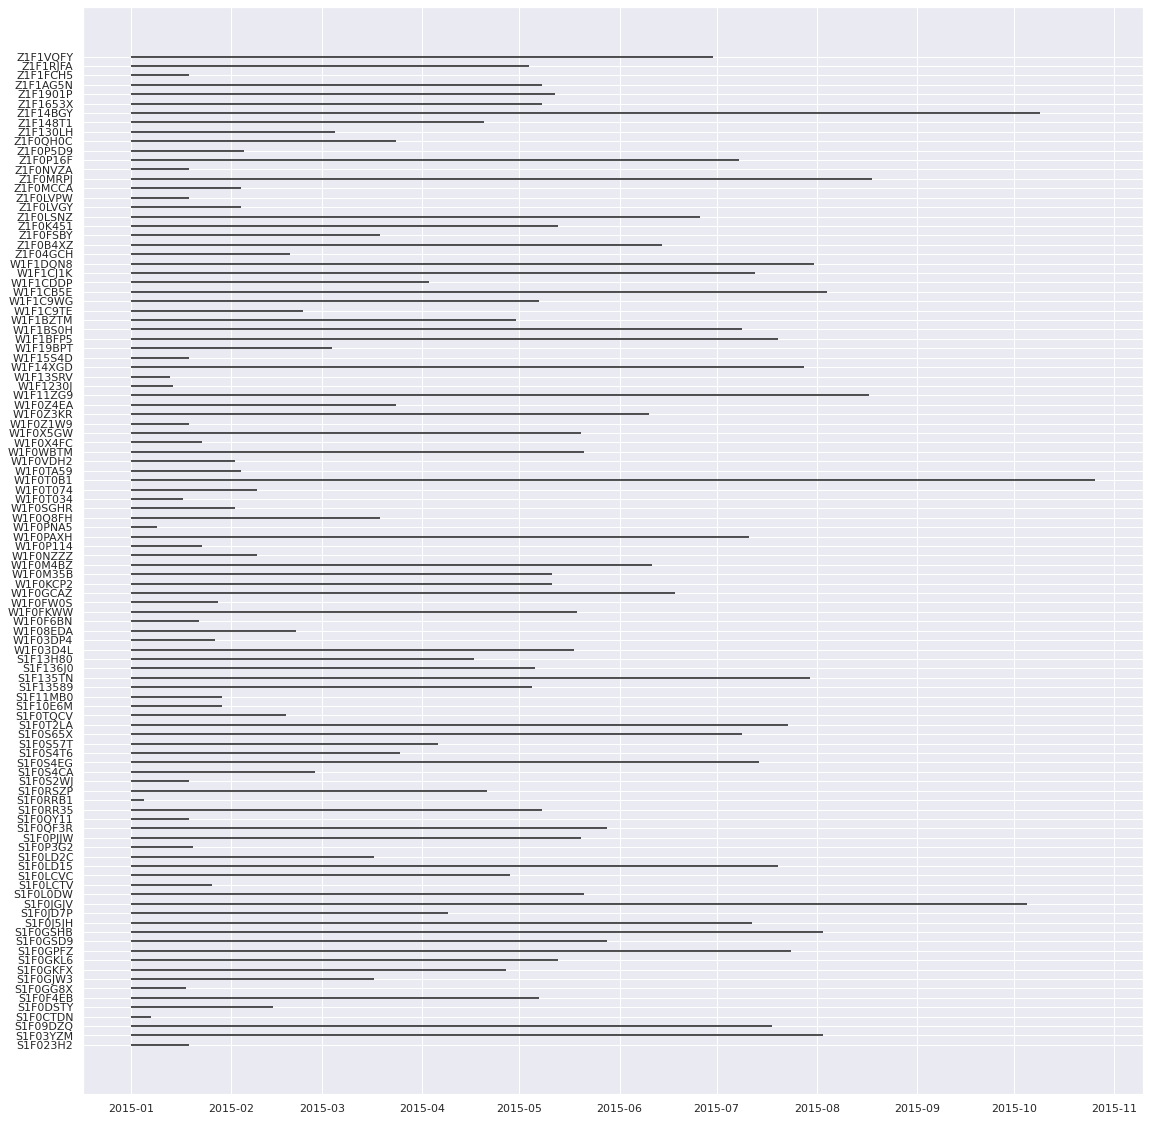

In [24]:
df = failures_desc.rename(columns={'device':'device',
                          'first':'Initial', # we have to change names sin "first" is reserved
                          'last':'Final'})

fig = plt.figure(figsize=(19,20))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df.device, dt.date2num(df.Initial), dt.date2num(df.Final))

In [25]:
failures[failures.device == "S1F0RRB1"]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1,1.0
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1,1.0
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1,1.0
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1,1.0
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1,1.0


We do not have a regular pattern over a date range, failures can happen at week 2 or any other week. We cannot take this problem with a time series perspective since it'll have the property that predictions will be based on a window with only a week maybe two as history and the need to drop observations.

As a first conclusion, we have to treat this problem as a supervised machine learning problem, in particular a binary classification task on the target variable 'failure'.

# Data Processing and Feature selection

In [26]:
process_cols = ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']

In [27]:
# A descriptive analysis will help to understand relation between variables
# 
devices[process_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [30]:
## It seems we have two very similar variables: attribute7 and attribute8

In [14]:
# We can also look at the correlation matrix between variables:

corr = devices[process_cols].corr() 
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000,-0.004,0.004,0.002,-0.003,-0.002,0.000,0.000,0.001
attribute2,-0.004,1.000,-0.003,0.147,-0.014,-0.026,0.141,0.141,-0.003
attribute3,0.004,-0.003,1.000,0.097,-0.007,0.009,-0.002,-0.002,0.532
attribute4,0.002,0.147,0.097,1.000,-0.010,0.025,0.046,0.046,0.036
attribute5,-0.003,-0.014,-0.007,-0.010,1.000,-0.017,-0.009,-0.009,0.006
attribute6,-0.002,-0.026,0.009,0.025,-0.017,1.000,-0.012,-0.012,0.021
attribute7,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute8,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute9,0.001,-0.003,0.532,0.036,0.006,0.021,0.007,0.007,1.000


We can see a very important issue here: attribute7 and attribute8 have correlation 1 and the same distribution. 

Most likely they are equal, but still no new information will be generated by keeping both variables.

In [28]:
devices.drop(columns=["attribute7"], axis=1, inplace=True)

# And we remove it also from the list of attributes for processing

process_cols.remove('attribute7')

In [29]:
# We can look now to linear correlation between variables and the target:

devices.corr()['failure'].sort_values(ascending=False)

failure       1.000000
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute6   -0.000550
attribute3   -0.000948
tag          -0.095136
Name: failure, dtype: float64

__Feature Selection__

 Before we proceed to selection method, attributes need to be standarized since ranges differ from each other and this will cause truble with selection by logistic regression.

In [30]:
# We create two pipelines for processing data so that we have them available for later use:

# We reserve PCA pipeline if needed.

num_pipeline = Pipeline([
    ("estandarizador", StandardScaler())
])


pipeline = ColumnTransformer([
    ("cont", num_pipeline, process_cols)#,
    #("pcas", PCA(n_components = 1, random_state=2020), process_cols)
])

In [19]:
df_num = pipeline.fit_transform(devices)

In [36]:
std_cols = ['x1', 'x2', 'x3' , 'x4', 'x5', 'x6', 'x7' , 'x8']

In [37]:
df_num = pd.DataFrame(df_num, columns=std_cols)

In [38]:
df_num["y"] = devices["failure"]

In [39]:
df_num.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479,0
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047,0
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047,0
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047,0
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375,0


In [40]:
X = df_num[std_cols].values
Y = df_num.y

In [41]:
poly = PolynomialFeatures(interaction_only=True)
X_int = poly.fit_transform(X)

In [42]:
selector = SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                        max_iter=200,
                                                        random_state=2020), 
                           threshold = 'median').fit(X_int, Y)
selector.estimator_.coef_

array([[-0.49533753,  0.18914722,  1.24371904, -5.52573988,  0.84532227,
        -0.23263094,  0.28724526,  1.48718155, -1.41304512, -0.11276852,
         1.85475531, -0.28057735,  0.17412718, -0.01439656,  0.44078069,
         1.52082723, -0.29364314, -0.02108822,  0.97060255,  0.91767086,
        -0.41926479,  1.03249105, -3.81830848, -6.05914619,  4.65637122,
        -0.47385241, -0.50548736,  0.65569993, -0.77778383,  0.14528875,
        -3.29678448,  0.39791156,  0.45544156, -1.15487165,  0.18035603,
        -0.51614393, -0.13894346]])

In [43]:
selector.get_support()

array([False, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
       False])

In [44]:
selector.threshold_

0.5054873617015109

We have a second conclusion: by feature selection with a logistic regression, we can drop the nearly uniformly distributed variable: attribute1 and others that show almost no correlation to the target. 

This is only a way to select a *strategy*: first we'll try with all the variables and only drop the ones we detect here to get better performance.

A third conclusion is the need for *interactions*, these mean nonlinear relation between attributes to help predicting the target.  

A good direction to take this nonlinear relations into account is the use of tree-based algorithms.

So, now we can draw a strategy for modelling: we'll try tree-based algorithms as benchmarks and from there we can search for an optimal model. Since nonlinear relations seem to be in the play, we can also try neural network architecture to solve our classification task.

# Modelling: Benchmark

In [31]:
###################
# target variable
y = devices.failure
###################

# We separate in train and test sets to measure the performance and to test generalization capacity of the models.

X_train, X_test, y_train, y_test = train_test_split(devices[process_cols],y,
                                                    test_size=0.3, 
                                                    stratify= y, 
                                                    random_state=2020)

# For the a later case we use the standarization pipeline build before.
# We apply it separately to avoid data leakage

X_train_lg = pipeline.fit_transform(X_train)
X_test_lg = pipeline.fit_transform(X_test)

#################################################

 Because we are dealing with imbalanced classes, not too many failures, it is a good practice to use a library to help over samplig.

 SMOTE is a technique used to help in the situation we have.

 SMOTE was proposed in 

 Bowyer, et al., 2002, SMOTE: Synthetic Minority Over-sampling Technique, 
 Journal of Artificial Intelligence Research 16 (2002) 321–357 
 (https://arxiv.org/pdf/1106.1813.pdf, accessed on July 2020).

In [32]:
sm = SMOTE(random_state = 2)

# over sampling for stadandarized sets:

X_train_rlg, y_train_rlg = sm.fit_sample(X_train_lg, y_train.ravel())

# We'll try tree based algorithms so we have no need to stadandarize, but still have to balance the sets:

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [55]:
y_train_rlg = pd.DataFrame(y_train_rlg, columns=['y'])
X_train_rlg = pd.DataFrame(X_train_rlg, columns=process_cols)
X_test_lg = pd.DataFrame(X_test_lg, columns=process_cols, index=X_test.index)
X_train_lg = pd.DataFrame(X_train_lg, columns=process_cols, index=X_train.index)
X_train_res = pd.DataFrame(X_train_res, columns=process_cols)
y_train_res = pd.DataFrame(y_train_rlg, columns=['y'])

## PROTOTYPES

The simplest prototypes we can try are decission trees. But we'll build also the popular ensembles: random forest and gradient boosting machines.


In [34]:
# To test these benchmarks we'll copy the devices data frame:
eval_devices = devices.copy()

# And weork with this to save results.

In [138]:
# Decission Tree Classifier

dtc = DecisionTreeClassifier(max_depth=8, criterion = 'entropy',
                                  max_features="auto", 
                                  class_weight="balanced", 
                                  min_samples_split = 10,
                                  #ccp_alpha= 0.0001,
                                  random_state=2020)

dtc = dtc.fit(X_train_res,y_train_res)

In [36]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=260, 
        max_features='auto', max_depth= 8,
        bootstrap=True, ccp_alpha = 0.0001,
        oob_score=True, n_jobs=-1, random_state=2020, 
        class_weight='balanced')

rfc = rfc.fit(X_train_res,y_train_res)

In [37]:
# Gradient Boosting Classifier

gbc = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features=7, validation_fraction=0.1, 
                           n_estimators=250, n_iter_no_change=12,
                           random_state=2020, subsample=0.95)

# In the experiments dopne before constructing the report, it's a good remark that theres no need for too many estimators.

gbc = gbc.fit(X_train_res, y_train_res)

In this step, we go to the usual evaluation on train and test sets. And present the classification report:

In [139]:
print('Accuracy DTC on train',dtc.score(X_train, y_train))
print('Accuracy DTC on test',dtc.score(X_test, y_test))

print('Accuracy RFC on train',rfc.score(X_train, y_train))
print('Accuracy RFC on test',rfc.score(X_test, y_test))


print('Accuracy GBC on train',gbc.score(X_train, y_train))
print('Accuracy GBC on test',gbc.score(X_test, y_test))

Accuracy DTC on train 0.9460439497389408
Accuracy DTC on test 0.9449516720661865
Accuracy RFC on train 0.962568133570486
Accuracy RFC on test 0.9612037805563737
Accuracy GBC on train 0.9042056342876814
Accuracy GBC on test 0.9049238266084768


In [140]:
# In the following reports, the cutoff at 0.5 is used by default:

classes_dtc = dtc.predict(X_test)
print(classification_report(classes_dtc, y_test))

classes_rfc = rfc.predict(X_test)
print(classification_report(classes_rfc, y_test))

classes_gbc = gbc.predict(X_test)
print(classification_report(classes_gbc, y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     35291
           1       0.53      0.01      0.02      2058

    accuracy                           0.94     37349
   macro avg       0.74      0.50      0.49     37349
weighted avg       0.92      0.94      0.92     37349

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35892
           1       0.62      0.01      0.03      1457

    accuracy                           0.96     37349
   macro avg       0.79      0.51      0.50     37349
weighted avg       0.95      0.96      0.94     37349

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     33778
           1       0.81      0.01      0.01      3571

    accuracy                           0.90     37349
   macro avg       0.86      0.50      0.48     37349
weighted avg       0.90      0.90      0.86     37349



Now we can put the labels and report what happens in the failure detection case:

In [40]:
eval_devices["predict_dtc"] = dtc.predict_proba(eval_devices[process_cols])[:,1]
eval_devices["predict_rfc"] = rfc.predict_proba(eval_devices[process_cols])[:,1] 
eval_devices["predict_gbc"] = gbc.predict_proba(eval_devices[process_cols])[:,1]

In [41]:
eval_devices.loc[:, 'label_dtc'] = 1 * (eval_devices.loc[:, 'predict_dtc'] > .6) 
eval_devices.loc[:, 'label_rfc'] = 1 * (eval_devices.loc[:, 'predict_rfc'] > .6) 
eval_devices.loc[:, 'label_gbc'] = 1 * (eval_devices.loc[:, 'predict_gbc'] > .6) 

In [42]:
eval_devices[eval_devices.failure==1].label_dtc.value_counts(normalize=True)

1    0.688679
0    0.311321
Name: label_dtc, dtype: float64

In [45]:
eval_devices[eval_devices.failure==1].label_rfc.value_counts(normalize=True)

1    0.641509
0    0.358491
Name: label_rfc, dtype: float64

In [46]:
eval_devices[eval_devices.failure==1].label_gbc.value_counts(normalize=True)

1    0.688679
0    0.311321
Name: label_gbc, dtype: float64

We save the prototypes for later use and comparison.

In [50]:
pickle.dump(dtc, open('dtc.pkl', 'wb'))

In [51]:
pickle.dump(rfc, open('rfc.pkl', 'wb'))

In [52]:
pickle.dump(gbc, open('gbc.pkl', 'wb'))

# TUNE THE PROTOTYPES

The following step is to work with this prototypes to optimize an error function and with the help of the Precision-Recall curves do a better job at choosing the right model.

## DECISION TREE CLASSIFIER

In [167]:
dtc_k = DecisionTreeClassifier(max_depth=8, criterion = 'gini',
                                  max_features="auto", 
                                  class_weight="balanced", 
                                  min_samples_split = 15,
                                  #ccp_alpha= 0.0001,
                                  random_state=2020)

In [168]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_res.index,columns=[0,1])

k_fold = StratifiedKFold(n_splits=6,shuffle=True,random_state=2020)

In [169]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    dtc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, dtc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = dtc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1])
print('Tree Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.23787592857649145
CV Log Loss:  0.23971719172245518
Training Log Loss:  0.17872504051280222
CV Log Loss:  0.1878420541909115
Training Log Loss:  0.19354159726384743
CV Log Loss:  0.20285314647691888
Training Log Loss:  0.19493407092917406
CV Log Loss:  0.20045864459978605
Training Log Loss:  0.23514214867463873
CV Log Loss:  0.23241137108541127
Training Log Loss:  0.223324974437936
CV Log Loss:  0.22242730590308832
Tree Log Loss:  0.21428480148291082


### Decision tree performance over resampled sets

Optimal Threshold=0.470588, F-Score=0.927


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.97')

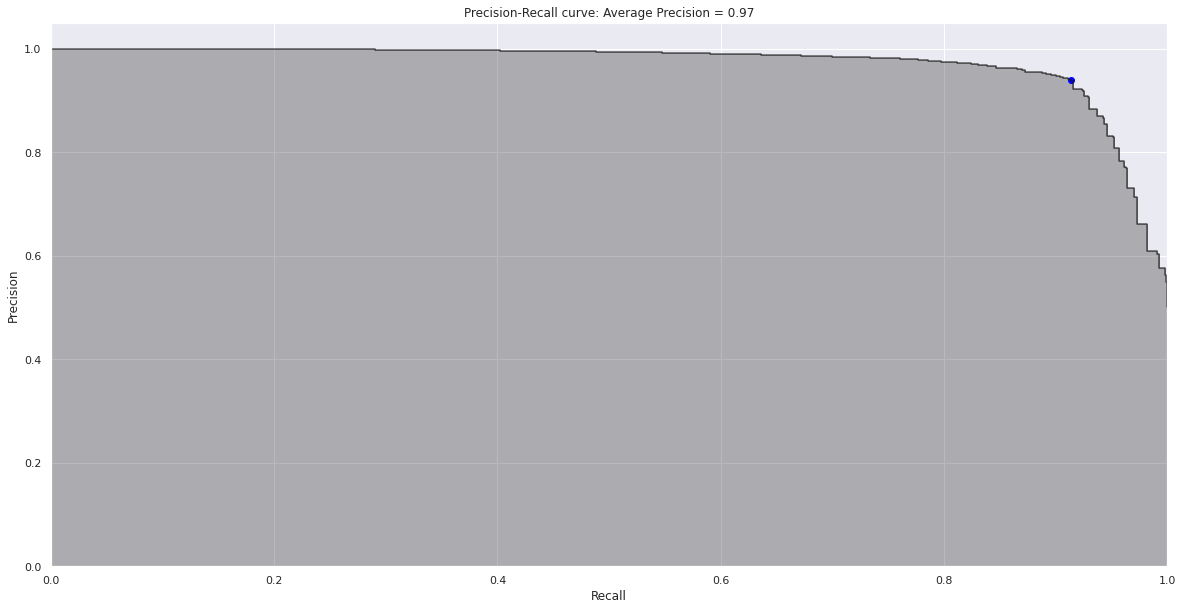

In [170]:
preds = pd.concat([y_train_res,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
corte = np.argmax(fscore)
print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))


plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

Optimal Threshold=0.516129


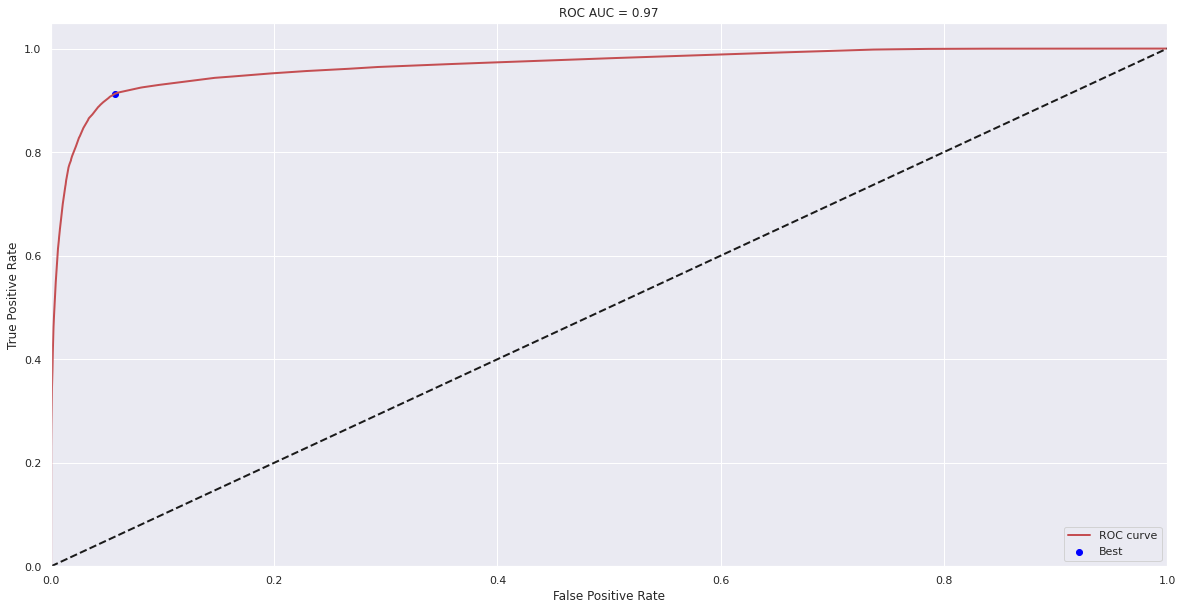

In [171]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

areaUnderROC = auc(fpr, tpr)

# To find the best threshold we can use Youden's statistic 
# J = Sensitivity + Specificity – 1
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic

# But we have that Sensitivity is the True Positive Rate
# And then J = Sensitivity + (1 – FalsePositiveRate) – 1
# Then

J = tpr - fpr
optim = np.argmax(J)
best_thresh = thresholds[optim]
print('Optimal Threshold=%f' % (best_thresh))


plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# optimal point
plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')
#
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Decision tree performance over train set and test

In [187]:
df_dtc = pd.DataFrame({'dtc_proba': dtc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_dtc.loc[:, 'label_dtc'] = 1 * (df_dtc.loc[:, 'dtc_proba'] > .5) 
df_dtc.describe()

,dtc_proba,true_class,label_dtc
count,87145.000000,87145.000000,87145.000000
mean,0.127729,0.000849,0.071020
std,0.184352,0.029128,0.256859
min,0.000000,0.000000,0.000000
25%,0.075272,0.000000,0.000000
50%,0.075272,0.000000,0.000000
75%,0.075272,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [188]:
df_dtc[df_dtc.true_class == 1].label_dtc.value_counts()

1    51
0    23
Name: label_dtc, dtype: int64

In [189]:
df_dtc[df_dtc.true_class == 0].label_dtc.value_counts()

0    80933
1     6138
Name: label_dtc, dtype: int64

In [196]:
# We can produce the important metrics:

def Metrics(y, pred):
    average_precision = average_precision_score(y, pred)
    
    print('Accuray:', accuracy_score(y, pred))
    print('Recall score:',recall_score(y, pred))
    print('Average_precision_score: ',average_precision_score(y, pred))
    print('Precision Score:',precision_score(y, pred))
    print('F1_score:',f1_score(y, pred))
    print('\n ConfusionMatrix: \n',confusion_matrix(y, pred))

In [197]:
Metrics(y_test, dtc_k.predict(X_test[process_cols]))

Accuray: 0.9285656911831642
Recall score: 0.71875
Average_precision_score:  0.006404747339168892
Precision Score: 0.008575689783743476
F1_score: 0.016949152542372885

 ConfusionMatrix: 
 [[34658  2659]
 [    9    23]]


## RANDOM FOREST

In [198]:
rfc_k = RandomForestClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=8,
                               min_samples_split = 15,
                       n_estimators=260, n_jobs=-1, oob_score=True,
                       random_state=2020)

In [199]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train_res.index,columns=[0,1])

In [200]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    rfc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, rfc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = rfc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('RFC Log Loss: ', loglossLogisticRegression) 
#Logistic Regression Log Loss:  0.5289955008268935

Training Log Loss:  0.15912834909894122
CV Log Loss:  0.1570223092941343
Training Log Loss:  0.15665697638590567
CV Log Loss:  0.15948960292824954
Training Log Loss:  0.1571094908768956
CV Log Loss:  0.1607531888717447
Training Log Loss:  0.15652084615851977
CV Log Loss:  0.15863826183079482
Training Log Loss:  0.1572426639501342
CV Log Loss:  0.15694194065701253
Training Log Loss:  0.15702147660802984
CV Log Loss:  0.15618503589359267
RFC Log Loss:  0.15817174171630735


### Random forest performance over resampled sets

In [201]:
def plotPerformance(y , preds, returnPreds = False):
    """
    y is a series, in notebook is y_train or a derived series made of the true labels
    preds are the prediction made by the classifier, in label form
    it can be the corresponding y_preds from train
    in notebook is predictionsBasedOnKFolds.loc[:,1] as taken from Chollet's book

    """
    preds = pd.concat([y, preds], axis=1)
    preds.columns = ['trueLabel', 'preds']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['preds'])
    average_precision = average_precision_score(preds['trueLabel'],preds['preds'])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    corte = np.argmax(fscore)
    print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['preds'])
    areaUnderROC = auc(fpr, tpr)
    J = tpr - fpr
    optim = np.argmax(J)
    best_cut = thresholds[optim]
    print('Optimal Threshold=%f' % (best_cut))

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # optimal cut
    plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')
    #
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

Optimal Threshold=0.587253, F-Score=0.951
Optimal Threshold=0.633443


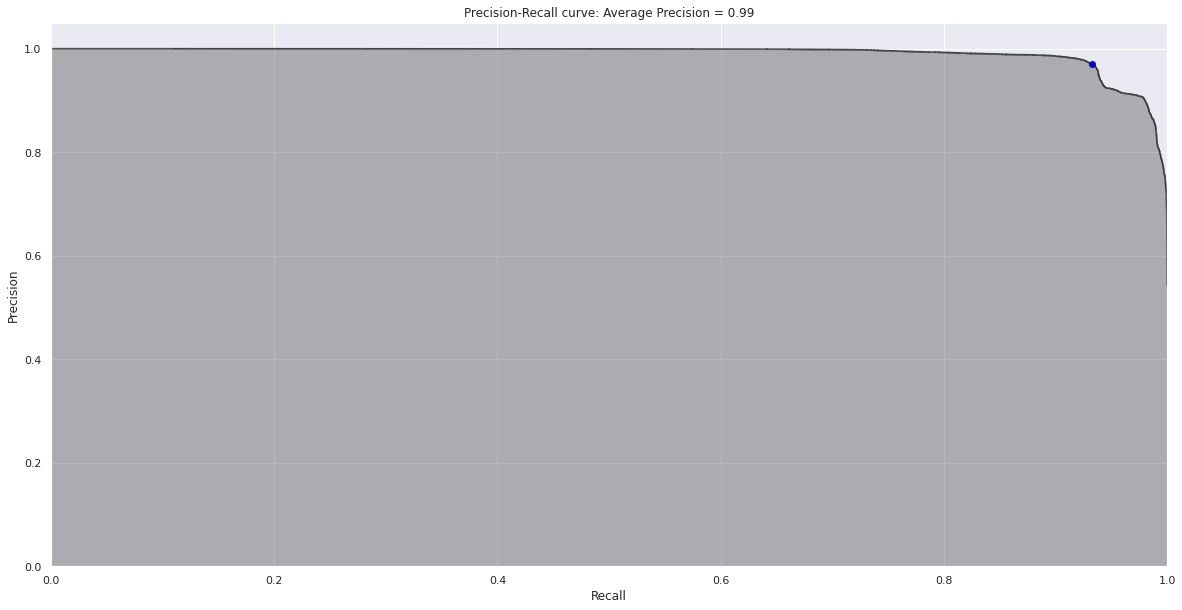

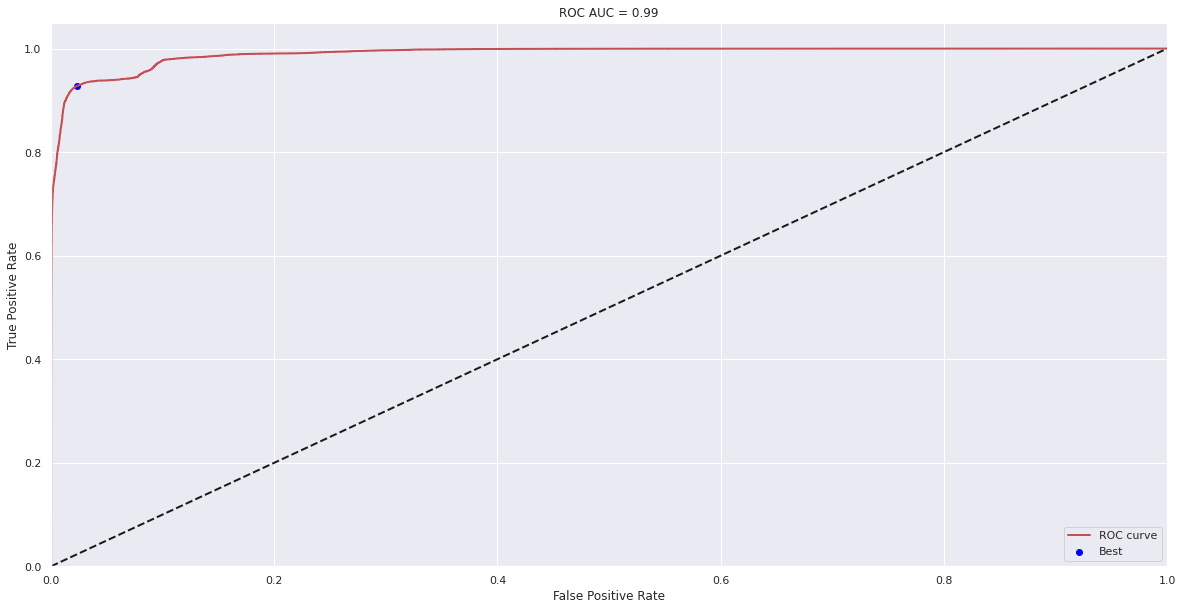

In [203]:
preds = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1],returnPreds=True)

### Random forest performance over train set and test

In [205]:
df_rfc = pd.DataFrame({'rfc_proba': rfc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_rfc.loc[:, 'label_rfc'] = 1 * (df_rfc.loc[:, 'rfc_proba'] > .5) 
df_rfc.describe()

,rfc_proba,true_class,label_rfc
count,87145.000000,87145.000000,87145.000000
mean,0.113851,0.000849,0.037604
std,0.140153,0.029128,0.190238
min,0.011631,0.000000,0.000000
25%,0.043464,0.000000,0.000000
50%,0.067592,0.000000,0.000000
75%,0.115437,0.000000,0.000000
max,0.989510,1.000000,1.000000


In [207]:
df_rfc[df_rfc.true_class == 1].label_rfc.value_counts()

1    52
0    22
Name: label_rfc, dtype: int64

In [208]:
Metrics(y_test, rfc_k.predict(X_test[process_cols]))

Accuray: 0.9616321722134461
Recall score: 0.625
Average_precision_score:  0.008995825318099292
Precision Score: 0.013879250520471894
F1_score: 0.027155465037338764

 ConfusionMatrix: 
 [[35896  1421]
 [   12    20]]


## Gradient boosting classifier

In [209]:
gbc_k = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features=7, validation_fraction=0.1, 
                           n_estimators=250, n_iter_no_change=12,
                           random_state=2020, subsample=0.95)

In [210]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train_res.index,columns=[0,1])

In [ ]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    gbc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, gbc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = gbc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('RFC Log Loss: ', loglossLogisticRegression) 
#Logistic Regression Log Loss:  0.5289955008268935

Training Log Loss:  0.32869738949580624
CV Log Loss:  0.32573457573760056
Training Log Loss:  0.3274257935334146
CV Log Loss:  0.3302932451738174
Training Log Loss:  0.327650344296417
CV Log Loss:  0.33046056457458317
Training Log Loss:  0.3277841869222503
CV Log Loss:  0.32920400029629887


In [ ]:
### Gradient Boosting performance over resampled sets

In [ ]:
preds = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1],returnPreds=True)

In [ ]:
### Random forest performance over train set and test

In [ ]:
df_rfc = pd.DataFrame({'rfc_proba': rfc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_rfc.loc[:, 'label_rfc'] = 1 * (df_rfc.loc[:, 'rfc_proba'] > .5) 
df_rfc.describe()

In [ ]:
df_rfc[df_rfc.true_class == 1].label_rfc.value_counts()

In [ ]:
Metrics(y_test, rfc_k.predict(X_test[process_cols]))

# MODEL 3: RANDOM FOREST

We'll try a tree based classifier.

In this case we do not need the standirized variables.

The following steps represent one way to search for hyperparameters in a given range.

In [92]:
pipe_rf = Pipeline([('classifier' , RandomForestClassifier(random_state=2020))])

param_grid_rf = [
    {'classifier' : [RandomForestClassifier(random_state=2020,
                                            criterion="gini", 
                                            max_features="auto", n_jobs=-1,
                                            oob_score= True
                                            #class_weight="balanced",
                                            )],
    'classifier__n_estimators' : list(range(200,381,20)),
    'classifier__max_depth' : list(range(7,9,1))
    } 
]

In [93]:
clf_rf = GridSearchCV(pipe_rf, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

In [94]:
best_rf = clf_rf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished


In [95]:
print(best_rf.best_estimator_.get_params()['classifier'])

RandomForestClassifier(max_depth=8, n_estimators=260, n_jobs=-1, oob_score=True,
                       random_state=2020)


In [124]:
print('Accuracy en entrenamiento rf',rfc.score(X_train_res, y_train_res))
print('Accuracy en prueba rf',rfc.score(X_test, y_test))

Accuracy en entrenamiento rf 0.9505461060513833
Accuracy en prueba rf 0.9622747596990548


In [125]:
classes_rf = rfc.predict(X_test)
print(classification_report(classes_rf, y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35936
           1       0.56      0.01      0.02      1413

    accuracy                           0.96     37349
   macro avg       0.76      0.51      0.50     37349
weighted avg       0.95      0.96      0.94     37349



We just found the best hyperparameters in a test range. Now we retrain the best model using k-fold cross validation.

In [142]:
n_estimators = 260
max_features = 'auto'
max_depth = 8
bootstrap = True
oob_score = True
n_jobs = -1
random_state = 2020
class_weight = 'balanced'

rfc = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        bootstrap=bootstrap, ccp_alpha = 0.0001,
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [38]:
y_train_res = pd.DataFrame(y_train_res, columns=['y'])
X_train_res = pd.DataFrame(X_train_res)

In [143]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_res.index,columns=[0,1])


for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),
                                          y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:], X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index], y_train_res.iloc[cv_index]
    
    rfc.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,rfc.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = rfc.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train_res,predictionsBasedOnKFolds.loc[:,1])
print('Random Forest Log Loss: ', loglossRandomForestsClassifier) # before Random Forest Log Loss:  0.15557334239967888

Training Log Loss:  0.15717281367956293
CV Log Loss:  0.15655048498837412
Training Log Loss:  0.155784178761904
CV Log Loss:  0.1602635284550046
Training Log Loss:  0.156060126959651
CV Log Loss:  0.1575966282402845
Training Log Loss:  0.1578571830954104
CV Log Loss:  0.15744552413151316
Training Log Loss:  0.15744512406583275
CV Log Loss:  0.1567249452521942
Random Forest Log Loss:  0.15771623014705138


Optimal Threshold=0.599189, F-Score=0.952
Optimal Threshold=0.619244


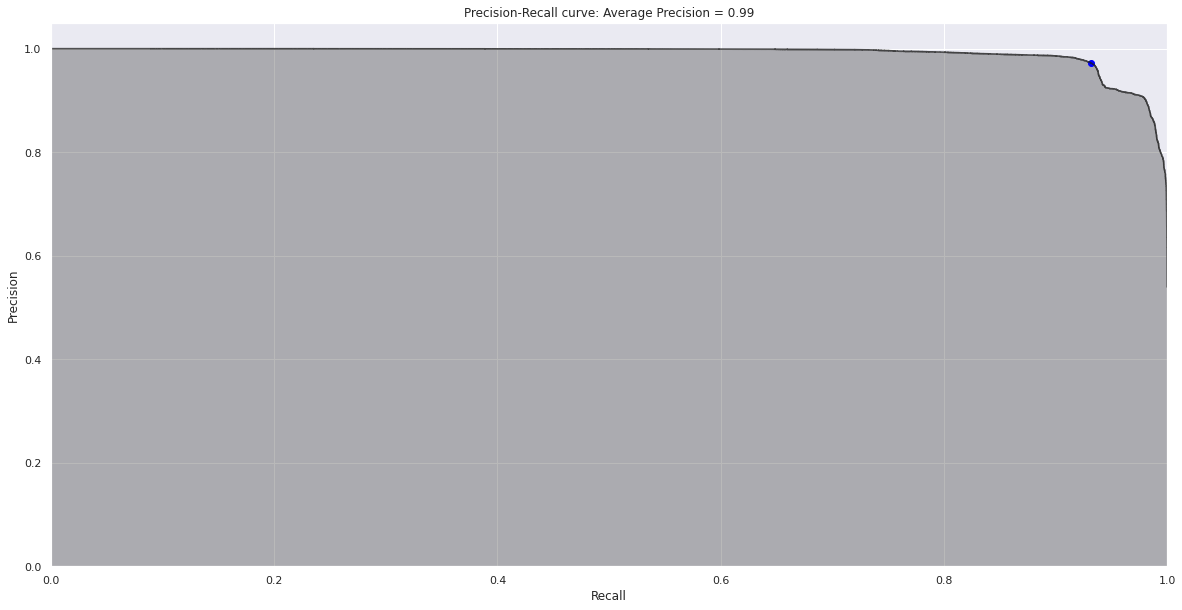

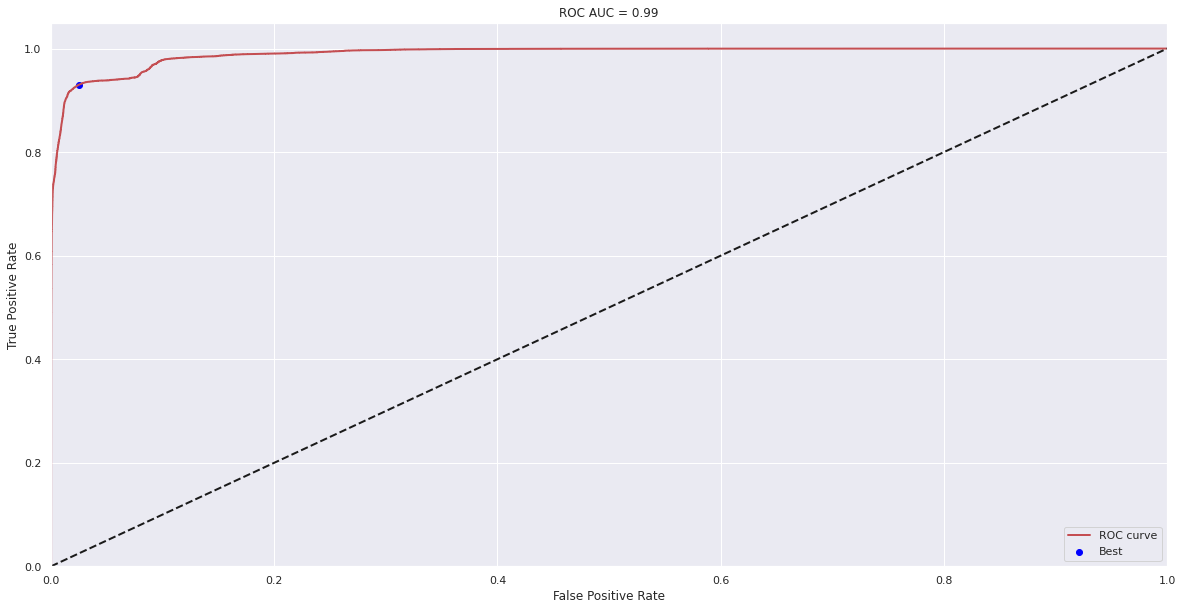

In [85]:
preds_rfc = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1], returnPreds=True)

__CONCLUSIONS FOR MODEL 3__

We have now a model that performs better than the logistic regression. The random forest has better metrics about precision and recall over the train set. However, we still need to see results on the validation set, were we can see if the models actually predict well device failure.

# BENCHMARK AUTOENCODER

It's important to try a model with an architecture comming from neural networks, especially beacause we have found that nonlinear relations between attributes are present.

The simplest solution is a binary classifier, but we'll try a different also common approach: __an Autoencoder__.

I followed the example given here: https://blog.keras.io/building-autoencoders-in-keras.html

It was easier since we have no images!

In [43]:
# The first is just a benchmark for an autoencoder, to see what comes out with the failures dataset.
# Call API
model = Sequential()

# Componets:
# Linear activation function to input layer
# Hidden layer with 16 nodes, the same as the input layer
# Linear activation function to hidden layer
# Output layer with 8 nodes

model.add(Dense(units=32, activation='relu',input_dim=8))

model.add(Dense(units=8, activation='linear'))

In [44]:
# Compile the model, later we'll move these parameters

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [45]:
# Train on the oversampled sets with standarization.

num_epochs = 5
batch_size = 50


# Here is the autoencoder part of the model. Inside the fit method, we'll pass the train set as input x
# but also as target and calculate the reconstruction error.

history = model.fit(x=X_train_rlg, y=X_train_rlg,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_rlg, X_train_rlg),
                    verbose=1).history

Epoch 1/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.5555 - accuracy: 0.8328 - val_loss: 0.0073 - val_accuracy: 0.9234
Epoch 2/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0033 - accuracy: 0.9302 - val_loss: 0.0012 - val_accuracy: 0.9247
Epoch 3/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0019 - accuracy: 0.9609 - val_loss: 0.0015 - val_accuracy: 0.9743
Epoch 4/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0029 - accuracy: 0.9783 - val_loss: 3.2916e-04 - val_accuracy: 0.9909
Epoch 5/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0012 - accuracy: 0.9825 - val_loss: 0.0066 - val_accuracy: 0.9849


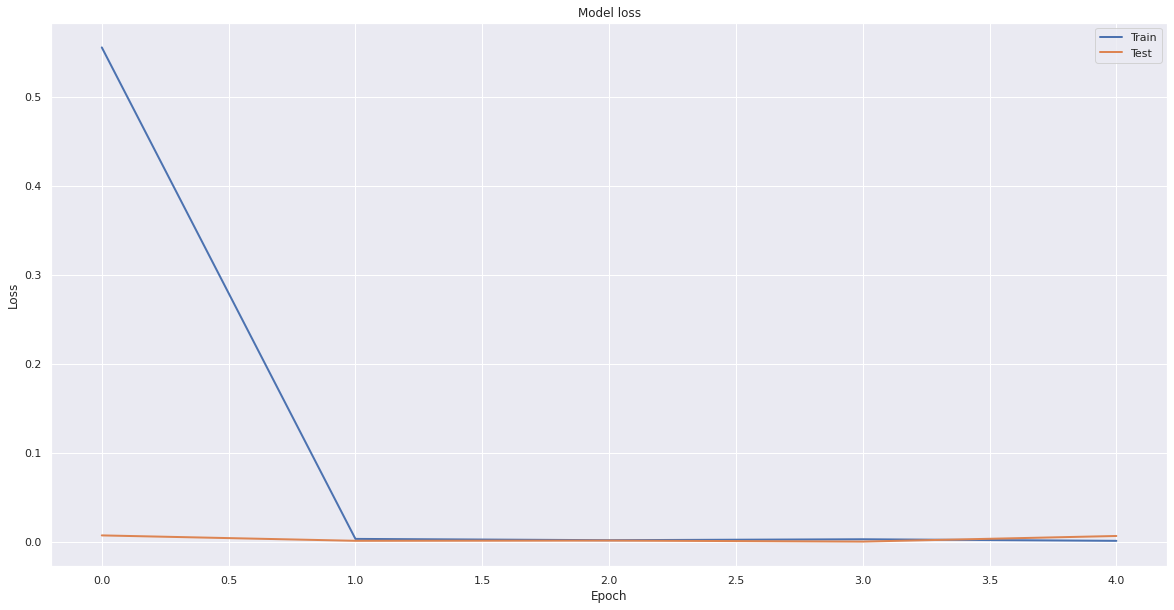

In [46]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [48]:
def is_failure_result(original_label, recons_label):
    recons_error = np.sum((np.array(original_label) - 
                   np.array(recons_label))**2, axis=1)
    recons_error = pd.Series(data=recons_error,index=original_label.index)
    recons_error = (recons_error-np.min(recons_error))/(np.max(recons_error)-np.min(recons_error))
    return recons_error

In [52]:
predictions = model.predict(X_test_lg, verbose=1)
failureScore = is_failure_result(X_test_lg, predictions)

1168/1168 [==============================] - 1s 584us/step


In [54]:
#predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(X_test_lg - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,37349.000000,37349.000000
mean,0.010452,0.000857
std,1.017878,0.029259
min,0.000004,0.000000
25%,0.000097,0.000000
50%,0.000219,0.000000
75%,0.000420,0.000000
max,195.915951,1.000000


In [ ]:
# A tipical number 

In [72]:
# error_df.loc[error_df["Reconstruction_error"] == 1, "pred_label"] = 1

In [71]:
#preds = plotPerformance(y_test, failureScore, True)
#model.reset_states()

# SECOND AUTOENCODER, NOT FOR DETECTION...

We can see from the PR curve that it has no average precision at all. So, instead of going trough hyperparameter optimization and regularization and architecture selection, it seems to be a better choice to use internal the internal representation of the autoencoder and give it to te supervised random forest. 

This is an example of a semi-supervised learning approach.

In [59]:
model = Sequential()
model.add(Dense(units=24, activation='relu', 
                activity_regularizer=regularizers.l1(1e-5),
                input_dim=8, name='hidden_layer'))
model.add(Dropout(0.01))
model.add(Dense(units=8, activation='relu'))

In [60]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [61]:
num_epochs =  5
batch_size = 100

history = model.fit(x=X_train_rlg, y=X_train_rlg, epochs=num_epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Epoch 1/5
1394/1394 [==============================] - 1s 1ms/step - loss: 0.8893 - accuracy: 0.7411 - val_loss: 0.1835 - val_accuracy: 0.8906
Epoch 2/5
1394/1394 [==============================] - 1s 1ms/step - loss: 0.2762 - accuracy: 0.8131 - val_loss: 0.1779 - val_accuracy: 0.9062
Epoch 3/5
1394/1394 [==============================] - 1s 1ms/step - loss: 0.2561 - accuracy: 0.8168 - val_loss: 0.1749 - val_accuracy: 0.9141
Epoch 4/5
1394/1394 [==============================] - 1s 1ms/step - loss: 0.2491 - accuracy: 0.8216 - val_loss: 0.1761 - val_accuracy: 0.9217
Epoch 5/5
1394/1394 [==============================] - 1s 1ms/step - loss: 0.2480 - accuracy: 0.8245 - val_loss: 0.1733 - val_accuracy: 0.9243


In [ ]:
predictions = model.predict(X_test_lg, verbose=1)
failures_p = is_failure_result(X_test_lg, predictions)
#preds, average_precision = plotPerformance(y_test, failures_p, True)

In [63]:
model.reset_states()

# SEMI-SUPERVISED LEARNING: AUTOENCODER-RANDOMFOREST

In [64]:
layer_name = 'hidden_layer'

intermediate_layer_model  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_rlg)
intermediate_output_test  = intermediate_layer_model.predict(X_test_lg)

In [65]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_rlg.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,index=X_test_lg.index)

In [66]:
X_train_aut = X_train_rlg.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test_aut  = X_test_lg.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train_aut = y_train_rlg.copy()

In [73]:
n_estimators = 260
max_features = 'auto'
max_depth = 8
bootstrap = True
oob_score = True
n_jobs = -1
random_state = 2020
class_weight = 'balanced'

aut_rfc = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        bootstrap=bootstrap, 
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [87]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_aut.index,columns=[0,1])


for train_index, cv_index in k_fold.split(np.zeros(len(X_train_aut)),
                                          y_train_aut.y.ravel()):
    X_train_fold, X_cv_fold = X_train_aut.iloc[train_index,:], X_train_aut.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_aut.iloc[train_index], y_train_aut.iloc[cv_index]
    
    aut_rfc.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,aut_rfc.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = aut_rfc.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train_res,predictionsBasedOnKFolds.loc[:,1])
print('Autoencoder-Random Forest Log Loss: ', loglossRandomForestsClassifier) # before Random Forest Log Loss:  0.15557334239967888

Training Log Loss:  0.14231394210736178
CV Log Loss:  0.1437879471910191
Training Log Loss:  0.14322519963793817
CV Log Loss:  0.1446658575110189
Training Log Loss:  0.14124278347740102
CV Log Loss:  0.14271223944196018
Training Log Loss:  0.14231496434257082
CV Log Loss:  0.14311459944743057
Training Log Loss:  0.14056819765875564
CV Log Loss:  0.1427093857425278
Autoencoder-Random Forest Log Loss:  0.1433980153865681


Optimal Threshold=0.647943, F-Score=0.973
Optimal Threshold=0.650139


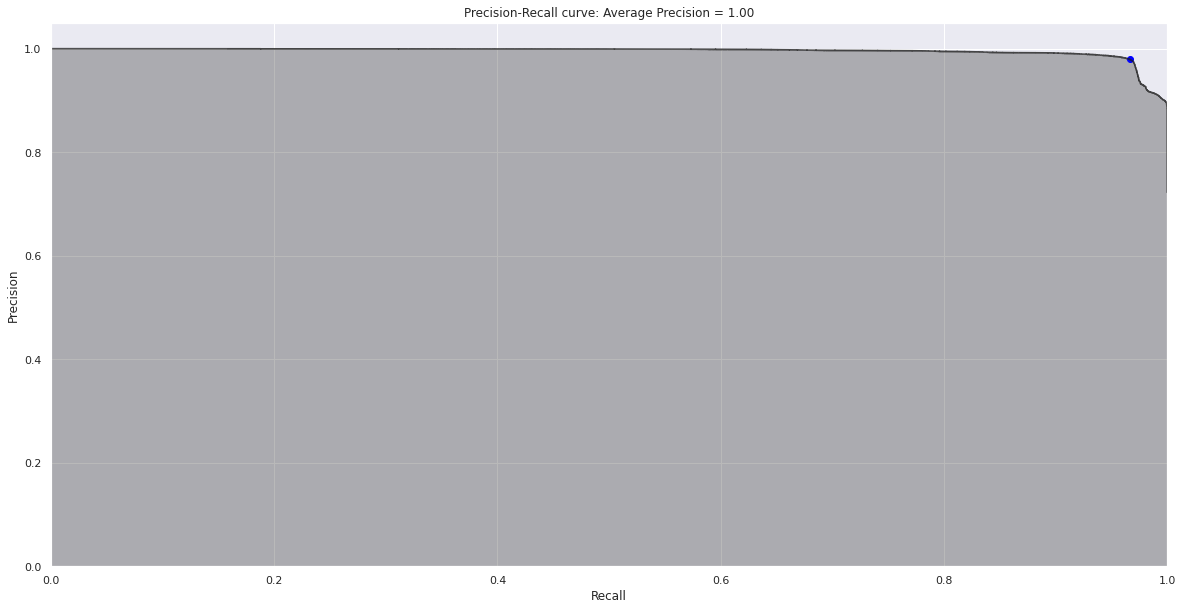

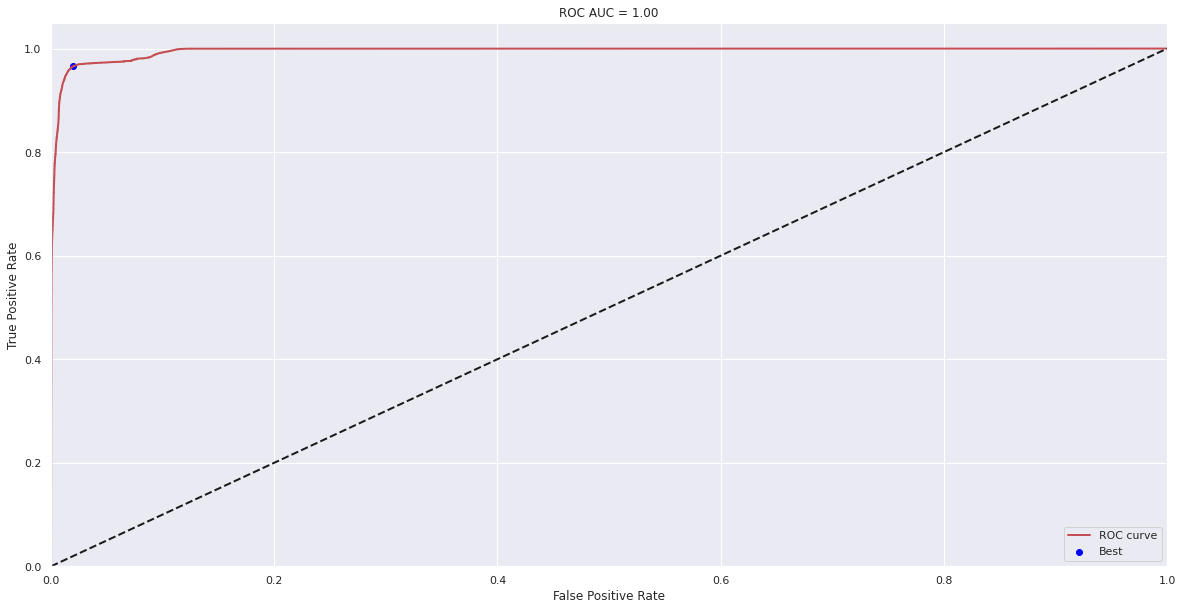

In [88]:
preds_aut = plotPerformance(y_train_aut, predictionsBasedOnKFolds.loc[:,1], True)
#Optimal Threshold=0.599890, F-Score=0.952
#Optimal Threshold=0.599890


In [77]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [89]:
preds_aut.shape

(174142, 2)

In [90]:
preds, precision = precisionAnalysis(preds_aut, "anomalyScore", 0.6)
print(f'{round(precision,4)}')

0.9989


# RESULTS ON TEST SET

In [117]:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = logReg.predict_proba(X_test_lg)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)

In [118]:
logLossTestSetLogisticRegression

0.5326994087488605

In [120]:
# X_test_lg2
preds_Test_lg_int = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
preds_Test_lg_int.loc[:,'prediction'] = logReg_int.predict_proba(X_test_lg2)[:,1]
logLoss_lg_int = log_loss(y_test, preds_Test_lg_int)

In [121]:
logLoss_lg_int

0.5090951233391061

In [144]:
predictionsTestSetRandomForests = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = rfc.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = log_loss(y_test, predictionsTestSetRandomForests)

In [145]:
logLossTestSetRandomForests

0.14599863080563444

In [94]:
predictionsTestSetRandomForests

,prediction
76947,0.105050
57161,0.103227
98767,0.474624
105826,0.066657
99344,0.383917
...,...
21024,0.029976
45220,0.049899
30140,0.058212
65250,0.085379


In [97]:
eval_devices = devices.copy()

In [146]:
eval_devices["predict_rfc"] = rfc.predict_proba(eval_devices[process_cols])[:,1] # y = gb.predict(X[X_cols])[0]


In [147]:
eval_devices.loc[:, 'label_rfc'] = 1 * (eval_devices.loc[:, 'predict_rfc'] > .55) #0.599189, 619244

In [172]:
eval_devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9,predict_rfc,label_rfc,predict_dtc,label_dtc,predict_gb,label_gb
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0.485808,0,0.103516,0,0.055438,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0.069422,0,0.009302,0,0.005157,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0.076044,0,0.080413,0,0.029416,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0.040560,0,0.258679,0,0.014856,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,0.121423,0,0.080413,0,0.071569,0


In [149]:
eval_devices[eval_devices.failure==1].label_rfc.value_counts(normalize=True)

1    0.669811
0    0.330189
Name: label_rfc, dtype: float64

In [161]:
from sklearn.tree import DecisionTreeClassifier
dt2_model = DecisionTreeClassifier(max_depth=8,
                                  max_features="auto", 
                                  class_weight="balanced", 
                                  min_samples_leaf = 3,
                                  ccp_alpha= 0.0001,
                                  random_state=2020)
#click.echo("Modelo extremo podado")

dtm_ex = dt2_model.fit(X_train_res,y_train_res)

In [162]:
eval_devices["predict_dtc"] = dtm_ex.predict_proba(eval_devices[process_cols])[:,1] # y = gb.predict(X[X_cols])[0]

In [163]:
eval_devices.loc[:, 'label_dtc'] = 1 * (eval_devices.loc[:, 'predict_dtc'] > .6) #0.599189, 619244

In [186]:
eval_devices[eval_devices.failure==1].label_dtc.value_counts(normalize=True)

1    0.688679
0    0.311321
Name: label_dtc, dtype: float64

In [196]:
from sklearn.ensemble import GradientBoostingClassifier

final_gbc = GradientBoostingClassifier(learning_rate=0.005, max_features=7, validation_fraction=0.1, 
                           n_estimators=320, n_iter_no_change=12,
                           random_state=2020, subsample=0.97)

In [197]:
final_gb = final_gbc.fit(X_train_res, y_train_res)

In [198]:
eval_devices["predict_gb"] = final_gb.predict_proba(eval_devices[process_cols])[:,1] # y = gb.predict(X[X_cols])[0]

In [201]:
eval_devices.loc[:, 'label_gb'] = 1 * (eval_devices.loc[:, 'predict_gb'] > .6) #0.599189, 619244

In [202]:
eval_devices[eval_devices.failure==1].label_gb.value_counts(normalize=True)

1    0.688679
0    0.311321
Name: label_gb, dtype: float64

# Pendientes


### 4. Paso 3: Aprendizaje semi-supervisado
### 6. Evaluaciones: tabla comparativa de performance
### 7. Limpieza del reporte